# Machine Learning with DeepChem

The goal of this worksheet is to get familiar with DeepChem and comfortable with the type of exercises we will provide, and how they shall be marked.

The emphasis here is also on learning to program with Python 3. Most steps of this workbook have code to test them - if you're passing these tests you should get most, if not all, of the marks.

## Marking and Submission

These lab exercises are marked, and contribute to your final grade. This lab exercise has **FILL ME** marks to earn, equivalent to **FILL ME**% of your final grade. Most of the time where you have to add code is indicated by:

`# **************************************************************** 2 marks`

with instructions above the code block. Occasionally a markdown block will request that you return to an early block and edit it. There will be no indicator in such cases.

Please submit your completed workbook using **FILL ME** before **FILL ME** on **FILL ME**. The workbook you submit must be an .ipynb file, which is saved into the directory you're running Jupyter; alternatively you can download it from the menu above using `File -> Download As -> Notebook (.ipynb)`. Remember to save your work regularly (`Save and checkpoint` in the `File` menu, the icon of a floppy disk, or `Ctrl-S`); the version you submit should have all code blocks showing the results (if any) of execution below them. You will normally receive feedback within a **FILL ME**.

---

## Import

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import deepchem as dc

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
RDKit WARNING: [11:28:47] Enabling RDKit 2019.09.3 jupyter extensions


In [3]:
tox21_tasks, tox21_datasets, transformers = dc.molnet.load_tox21()

Loading raw samples now.
shard_size: 8192
About to start loading CSV from /var/folders/tc/glv8wyj53p919jdn9hpdvjsm0000gn/T/tox21.csv.gz
Loading shard 1 of size 8192.
Featurizing sample 0


RDKit WARNING: [11:29:01] WARNING: not removing hydrogen atom without neighbors


Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
TIMING: featurizing shard 0 took 17.550 s
TIMING: dataset construction took 17.833 s
Loading dataset from disk.
TIMING: dataset construction took 0.369 s
Loading dataset from disk.
TIMING: dataset construction took 0.229 s
Loading dataset from disk.
TIMING: dataset construction took 0.311 s
Loading dataset from disk.
TIMING: dataset construction took 0.322 s
Loading dataset from disk.
TIMING: dataset construction took 0.051 s
Loading dataset from disk.
TIMING: dataset construction took 0.046 s
Loading dataset from disk.


The _enzymatic assay_ measures whether molecules bind with _biological target_. Each task in 12 ``tox21_tasks`` given below represents one such _assay_ target, each of which is supposedly linked to toxic responses to potential therapeutic molecules.

In [4]:
tox21_tasks

['NR-AR',
 'NR-AR-LBD',
 'NR-AhR',
 'NR-Aromatase',
 'NR-ER',
 'NR-ER-LBD',
 'NR-PPAR-gamma',
 'SR-ARE',
 'SR-ATAD5',
 'SR-HSE',
 'SR-MMP',
 'SR-p53']

If your background isn't in biology, it might be easier to understand some of the terms with computer science analogies.

You can imagine cells or animals as complex legacy codebases that one normally has no control over, however, you as an engineer have a few experimental measurements of these systems (assays) which you can use to gain some understanding of the underlying mechanics.

Machine learning is an extraordinarily powerful tool for understanding biological systems, as algorithms are capable of autonomously extracting meaningful correlations, which allows even biology-beginners to sometimes find deep insights.

In [5]:
tox21_datasets

(<deepchem.data.datasets.DiskDataset at 0x1c4d7cdf90>,
 <deepchem.data.datasets.DiskDataset at 0x1c4e065050>)

The `tox21_datasets` variable is actually a tuple, containing the training, validation, and testing data.

We can extract it as following:

In [6]:
train_dataset, valid_dataset, test_dataset = tox21_datasets

In [7]:
print('Dataset shapes:')
print()
print('Train :', train_dataset.X.shape)
print('Valid :', valid_dataset.X.shape)
print('Test  :', test_dataset.X.shape)

Dataset shapes:

Train : (6264, 1024)
Valid : (783, 1024)
Test  : (784, 1024)


## 1. Warm up

Fill in the blanks in the cell below to print out the shape of the _labels_ i.e. **y** dataset of the `train_dataset`, `valid_dataset`, and `test_dataset`.

__(1 mark)__

In [8]:
print('Dataset label shapes:')
print()
# **************************************************************** (1 mark)

# The output should be:
# (6264, 12)
# (783, 12)
# (784, 12)

Dataset label shapes:



These are the 12 data point, also known as *labels*, for each sample. These correspond to the 12 tasks we discussed earlier. 

In this particular dataset:

- The samples correspond to molecules
- The tasks correspond to biochemical assays
- Each label is the result of a particular assay on a particular molecule.

We want our model to predict these labels.

However, ...

In [9]:
train_dataset.w.shape

(6264, 12)

In [10]:
np.count_nonzero(train_dataset.w)

62166

In [11]:
np.count_nonzero(train_dataset.w == 0)

13002

We can observe that out of the total 6,264 * 12 = 75,168 elements in our array (table), only **62,166** were actually measured, i.e. 62,166 / 75,168 => ~82.7% of of the entire dataset.

The other 75,168 - 62,166 = **13,002** values correspond to missing measurements and should be ignored for our purposes. It is common for datasets to include empty values simply for convenience, as dealing with irregular shaped arrays is significantly harder than regular matrices.

---

DeepChem provides many *transformers*, which are objects which modify the dataset in some way. The `transformers` variable shown below is a `BalancingTransformer`.

In [12]:
transformers

This transformer is relevant for datasets which have a high class-imbalance. For example, **90%** of the the molecules in `tox21_datasets` did not bind to most of their targets, and thus have a label of 0. 

This means a model could easily achieve a 90% accuracy by *always* predicting the label as 0, regardless of the input values, but would also be unequivocally useless.

Which is why we use `BalancingTransformer` to transform the dataset's matrix of weights so that the total weight assigned to every class is the same. Hence, the loss function has no systematic preference for any single class, and can thus learn to correctly distinguish between classes.

---

We build a fully connected 'multi-layered perceptron' model which maps input features to *multiple* output predictions, using the `dc.models.MultitaskClassifier()` class, which requires two parameters, `n_tasks` and `n_features`. 


In the following cell, instantiate the class with the correct parameters. Once constructed, train the model on the data.

Remember, we want to train the classifier on the Tox21 *training* dataset, which we briefly explored in the pre-warmup.

**(2 marks)**

In [161]:
# **************************************************************** (2 mark)
# model = dc.models.MultitaskClassifier(n_tasks=, n_features=)
# model.fit(dataset=)

In [162]:
model = dc.models.MultitaskClassifier(n_tasks=12, n_features=1024)
model.fit(dataset=train_dataset)

0.31932042886813483

In [182]:
#metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean)
metric = dc.metrics.Metric(dc.metrics.accuracy_score, np.mean)
#metric = dc.metrics.Metric(dc.metrics.precision_recall_curve, np.mean)

In [174]:
model.evaluate(train_dataset, [metric], transformers)

computed_metrics: [0.9479758828596038, 0.9764028242289112, 0.9083429008802143, 0.9335490830636461, 0.7004262228536635, 0.9078923604840167, 0.9501460564751704, 0.7201284796573876, 0.9568690095846646, 0.9328185328185328, 0.6918592096739365, 0.8242042931162102]


{'mean-accuracy_score': 0.8708845713079966}

In [165]:
train_scores = model.evaluate(train_dataset, [metric], transformers)
valid_scores = model.evaluate(valid_dataset, [metric], transformers)
test_scores = model.evaluate(test_dataset, [metric], transformers)

computed_metrics: [0.9479758828596038, 0.9764028242289112, 0.9083429008802143, 0.9335490830636461, 0.7004262228536635, 0.9078923604840167, 0.9501460564751704, 0.7201284796573876, 0.9568690095846646, 0.9328185328185328, 0.6918592096739365, 0.8242042931162102]


In [170]:
print(train_scores)
print(valid_scores)
print(test_scores)

{'mean-accuracy_score': 0.8708845713079966}
{'mean-accuracy_score': 0.8271924652255417}
{'mean-accuracy_score': 0.8117946048304927}


In [72]:
assert(train_scores==0.9785381916127314, 'Train Score Error')
assert(test_scores==0.7352941543057708, 'Val Score Error')
assert(test_scores==0.7659030760081582, 'Test Score Error')

We can observe that the ROC-AUC score is significantly higher for the train dataset, than the validation or test dataset, implying the model has trouble generalizing to unseen data, and has overfit the training data.

What about other metrics ? Acc ? Recall ? Precision ? F1 ?

### MNIST

This time we use the `dc.models.TensorGraph` class, which provides a framework for building custom deep neural network architectures using DeepChem.

First, we download the raw MNIST data files and store them locally:

In [73]:
mkdir MNIST_data
cd MNIST_data

In [84]:
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

--2020-02-27 14:16:01--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 216.165.22.6
Connecting to yann.lecun.com (yann.lecun.com)|216.165.22.6|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M   962KB/s    in 15s     

2020-02-27 14:16:19 (626 KB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]



In [96]:
cd ..

/Users/eklavya/Dropbox/aCubeIT/Drug


In [98]:
from tensorflow.examples.tutorials.mnist import input_data

In [99]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [100]:
import tensorflow as tf
import deepchem.models.tensorgraph.layers as layers

In [101]:
train_dataset = dc.data.NumpyDataset(mnist.train.images, mnist.train.labels)
test_dataset = dc.data.NumpyDataset(mnist.test.images, mnist.test.labels)


The `model_dir` parameter specifies a directory where the model's parameters should be saved.

In [127]:
# Get the model's parameters
model = dc.models.TensorGraph(model_dir='mnist')

In [128]:
# Define shapes of features and labels
feature = layers.Feature(shape=(None, 784))
label = layers.Label(shape=(None, 10))

In [129]:
# Reshape (?)
make_image = layers.Reshape(shape=(None, 28, 28), in_layers=feature)

In [130]:
# Layers of our NN
conv2d_1 = layers.Conv2D(num_outputs=32, activation_fn=tf.nn.relu, in_layers=make_image)
conv2d_2 = layers.Conv2D(num_outputs=64, activation_fn=tf.nn.relu, in_layers=conv2d_1)
flatten  = layers.Flatten(in_layers=conv2d_2)
dense1   = layers.Dense(out_channels=1024, activation_fn=tf.nn.relu, in_layers=flatten)
dense2   = layers.Dense(out_channels=10, activation_fn=None, in_layers=dense1)

In [131]:
# Softmax cross-entropy loss
smce = layers.SoftMaxCrossEntropy(in_layers=[label, dense2])
loss = layers.ReduceMean(in_layers=smce)
model.set_loss(loss)

In [132]:
# Output
output = layers.SoftMax(in_layers=dense2)
model.add_output(output)

In [133]:
# Fit
model.fit(train_dataset, nb_epoch=1)

0.11292030922221867

In [136]:
metric = dc.metrics.Metric(dc.metrics.accuracy_score)

In [135]:
train_scores = model.evaluate(train_dataset, [metric])
test_scores = model.evaluate(test_dataset, [metric])

computed_metrics: [0.2106909090909091]
computed_metrics: [0.2111]


In [137]:
print(train_scores)
print(test_scores)

{'accuracy_score': 0.2106909090909091}
{'accuracy_score': 0.2111}


## Featurizing Molecules

Below we explore some different ways of featurizing molecules into data usable for machine learning.

In [16]:
from rdkit import Chem

#### 1. SMILES

In [81]:
# We define two molecules - Cyclohexane and Dioxane - as SMILE strings
smiles = ['C1CCCCC1', 'O1CCOCC1']
print(smiles)

['C1CCCCC1', 'O1CCOCC1']


#### 2. Extended-Connectivity Fingerprints

In [82]:
# Convert from SMILE strings to chemical molecules using rdkit
mols = [Chem.MolFromSmiles(smile) for smile in smiles] 

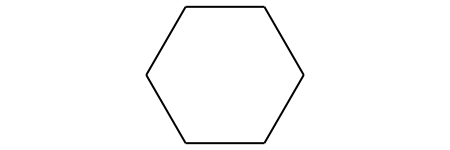

In [29]:
# Visualize
mols[0]

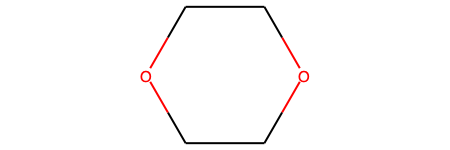

In [30]:
mols[1]

In [69]:
# Instanstiate a circular fingerprint featurizer 
feat = dc.feat.CircularFingerprint(size=1024)
print(feat)

In [70]:
# Use chosen featurizer to featurize the defined molecules into array of binary vectors aka 'fingerprints'
arr = feat.featurize(mols)
print('Array shape:', arr.shape)
print()
print(arr)

Array shape: (2, 1024)

[[0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [57]:
print('Smiles:       \t', smiles[0])
print('Molecules:    \t', mols[0])
print('Featurizer:   \t', feat)
print('Fingerprints: \t', arr[0])

Smiles:       	 C1CCCCC1
Molecules:    	 <rdkit.Chem.rdchem.Mol object at 0x1c4d7f7a80>
Featurizer:   	 <deepchem.feat.fingerprints.CircularFingerprint object at 0x1c4d7ea8d0>
Fingerprints: 	 [0 0 1 ... 0 0 0]


A fingerprint encodes a lot of information about the molecule, however it has one major pitfall:

It is possible for two *different* molecules to have **identical fingerprints**. Therefore, when given a fingerprint, it is impossible to *uniquely determine* what molecule it came from.

#### 2. Molecular Descriptors

In [73]:
# Instanstiate a molecular description featurizer
feat = dc.feat.RDKitDescriptors()

In [75]:
# Use chosen featurizer to featurize molecules into array containing chemical/physical properties of the molecules
arr = feat.featurize(mols)
print(arr.shape)

(2, 111)


In [80]:
# Note that these are different from the binary 'fingerprint' vectors from earlier,
# as these represent the actual physical descriptors on the molecules
print(arr[0][:10])

[ 1.50000000e+00  1.50000000e+00  1.50000000e+00  1.50000000e+00
  8.41620000e+01  7.20660000e+01  8.40939004e+01  3.60000000e+01
  0.00000000e+00 -5.33059728e-02]
